In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

In [2]:
def load_and_inspect_data(file_path):
    # Load the data
    data = pd.read_csv(file_path)
    
    # Check for duplicate rows
    duplicate_rows = data.duplicated().sum()
    
    # Check for missing values in each column as a percentage
    missing_values = data.isnull().mean() * 100
    
    # Create a DataFrame for missing values
    missing_values_df = pd.DataFrame(missing_values, columns=["missing values (%)"])
    
    # Add a row for duplicate rows
    inspection_results = pd.concat([pd.DataFrame({"missing values (%)": "N/A"}, index=["duplicate rows"]),
                                    missing_values_df])
    
    # Update the duplicate rows entry manually to avoid it being treated as a column
    inspection_results.at["duplicate rows", "missing values (%)"] = duplicate_rows
    
    # Display the table
    print(inspection_results)

In [3]:
load_and_inspect_data('nvidia_stock_2015_to_2024.csv')

               missing values (%)
duplicate rows                  0
Unnamed: 0                    0.0
date                          0.0
open                          0.0
high                          0.0
low                           0.0
close                         0.0
adjclose                      0.0
volume                        0.0


In [4]:
def clean_dataframe(file_path):
    # Load the data
    data = pd.read_csv(file_path)
    
    # Remove 'Unnamed' columns
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

    #update the date column to datetime format
    data['date'] = pd.to_datetime(data['date'])
    
    # Remove duplicate rows
    data = data.drop_duplicates()
    
    # Remove rows with any missing values
    data = data.dropna()
    
    # Return the cleaned DataFrame
    return data

In [5]:
clean_data=clean_dataframe('nvidia_stock_2015_to_2024.csv')

In [6]:
def summarize_dataframe(data):
    # Data types of each column
    data_types = data.dtypes

    # Central tendency measures
    mean = data.mean()
    median = data.median()
    mode = data.mode().iloc[0]  # Mode might have multiple values; take the first for each column
    std = data.std()
    quartiles = data.quantile([0.25, 0.5, 0.75]).transpose()

    # Combine all summaries into a single DataFrame for display
    summary = pd.DataFrame({
        'Data Type': data_types,
        'Mean': mean,
        'Median': median,
        'Mode': mode,
        'Standard Deviation': std,
        '25%': quartiles[0.25],
        '50%': quartiles[0.5],
        '75%': quartiles[0.75]
    })

    # Handling non-numeric columns for mean, median, std, and quartiles by filling NaNs
    summary[['Mean', 'Median', 'Standard Deviation', '25%', '50%', '75%']].fillna('N/A', inplace=True)

    # Return the summary table
    return summary

In [7]:
summarize_dataframe(clean_data)

,Data Type,Mean,Median,Mode,Standard Deviation,25%,50%,75%
date,datetime64[ns],2019-09-16 01:22:03.596454144,2019-09-17 00:00:00,2015-01-02 00:00:00,992 days 13:44:33.962933008,2017-05-10 00:00:00,2019-09-17 00:00:00,2022-01-21 00:00:00
open,float64,14.188477,6.1915,0.52525,18.683473,2.99825,6.1915,17.915001
high,float64,14.445906,6.26275,0.559,19.020099,3.0455,6.26275,18.243999
low,float64,13.919531,6.0915,0.55125,18.31567,2.9475,6.0915,17.634001
close,float64,14.197878,6.17825,0.555,18.691694,3.03225,6.17825,17.983999
adjclose,float64,14.169242,6.1299,0.53496,18.697431,2.992067,6.1299,17.963766
volume,int64,478752639.088223,427796000.0,295420000.0,255987441.123194,318800000.0,427796000.0,574588000.0


In [8]:
def plot_distribution_and_outliers(data, column_names):
    """
    This function takes a DataFrame and a list of column names as input.
    It plots the distribution of the specified columns as histograms and their outliers as boxplots.
    """
    for column_name in column_names:
        # Check if the column exists in the DataFrame
        if column_name not in data.columns:
            print(f"Column '{column_name}' not found in the DataFrame.")
            continue
        
        # Set up the matplotlib figure
        fig, axs = plt.subplots(nrows=2, figsize=(10, 8))
        
        # Histogram
        sns.histplot(data[column_name], kde=True, ax=axs[0])
        axs[0].set_title(f'Distribution of {column_name}')
        
        # Boxplot
        sns.boxplot(x=data[column_name], ax=axs[1])
        axs[1].set_title(f'Outliers in {column_name}')
        
        plt.tight_layout()
        plt.show()

In [13]:
column_names = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

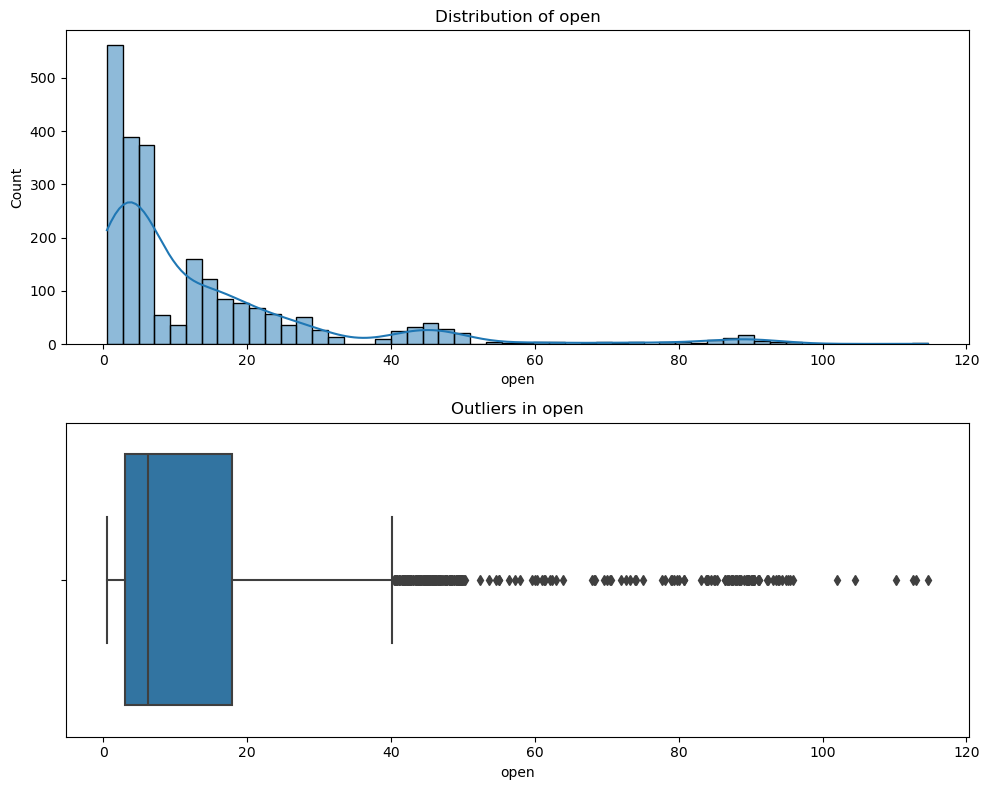

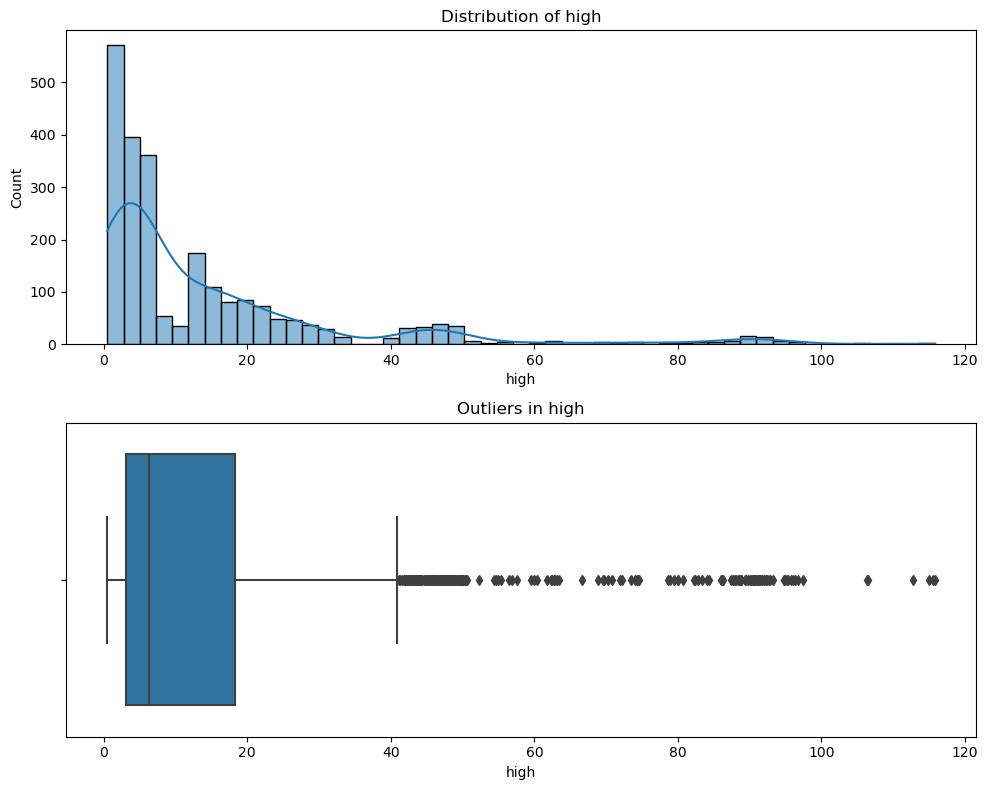

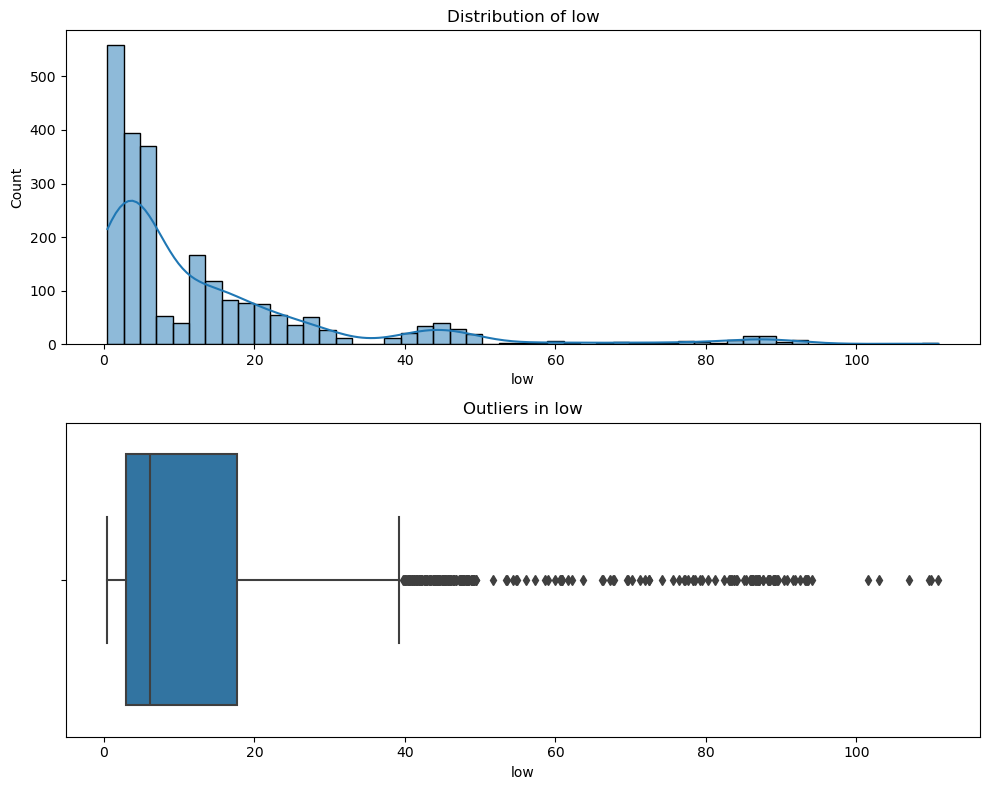

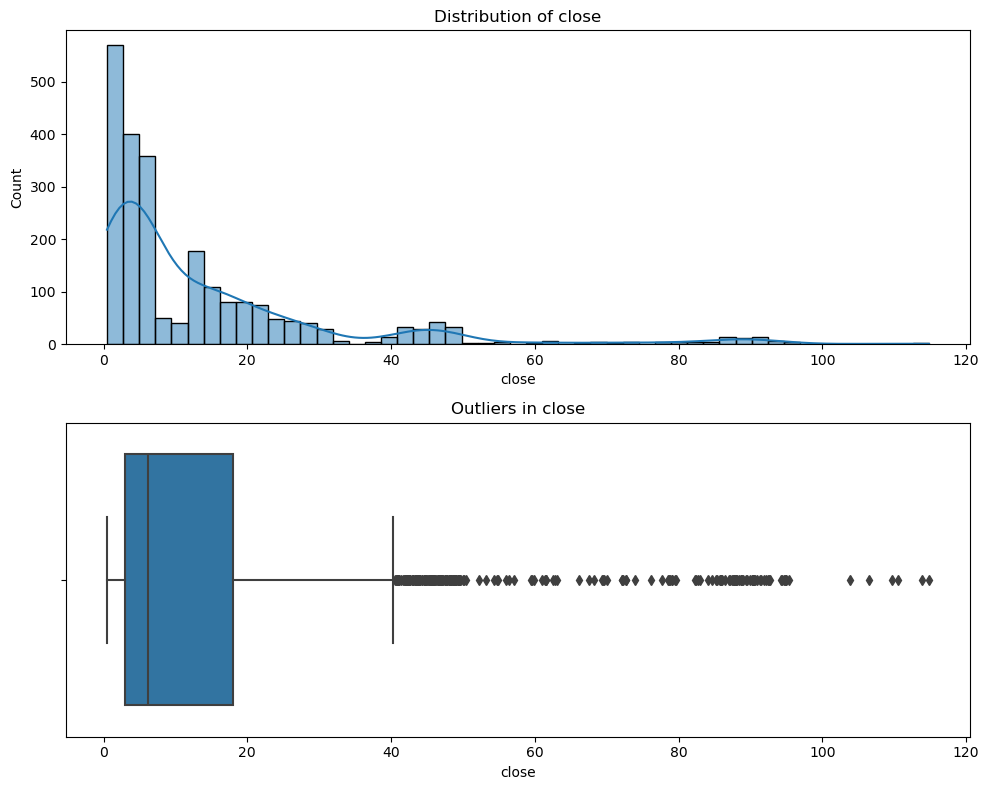

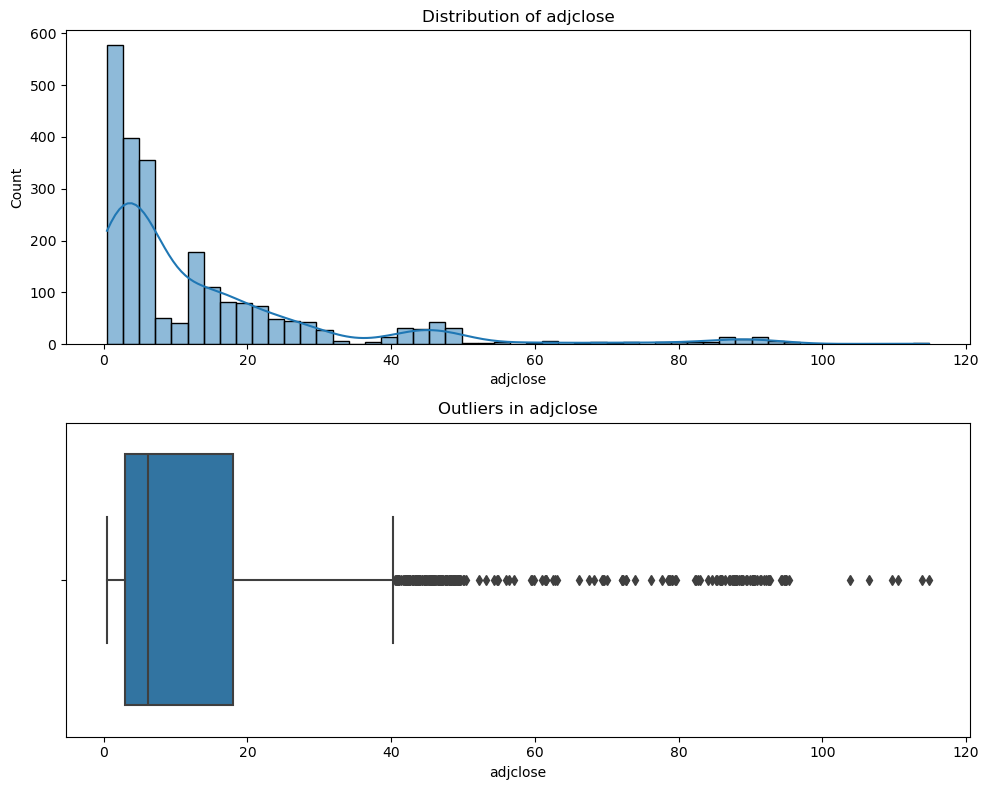

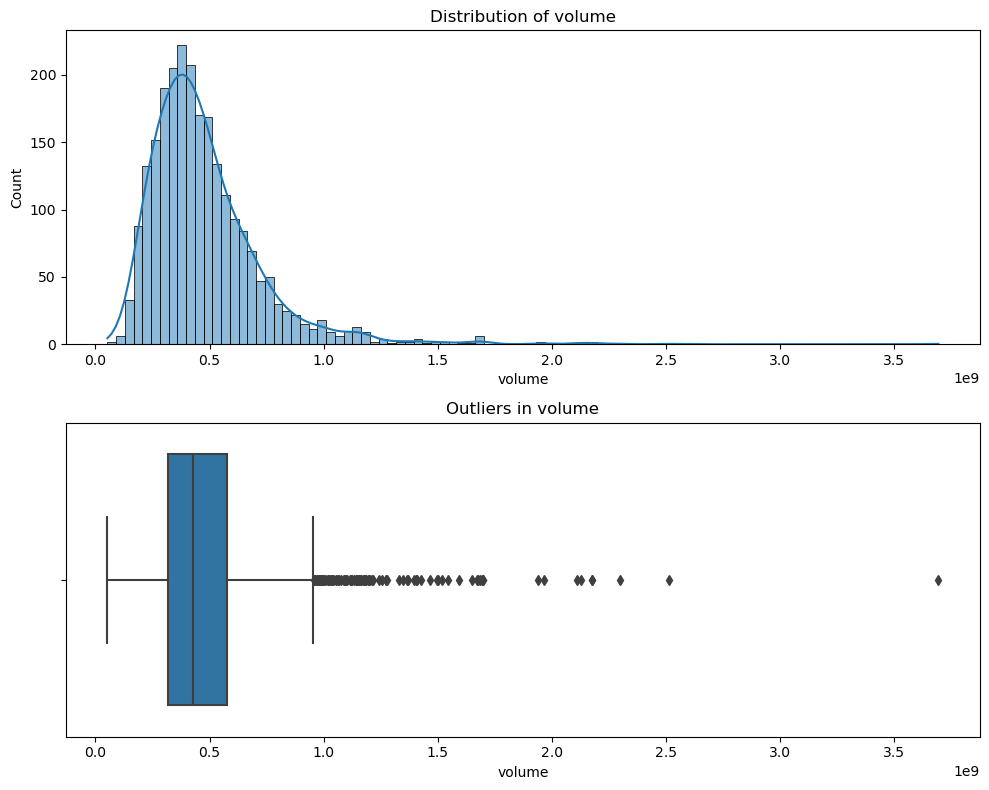

In [14]:
plot_distribution_and_outliers(clean_data, column_names)

In [62]:
import numpy as np

def remove_outliers_from_dataframe(data):
    """
    This function takes a DataFrame as input, removes outliers from all columns,
    and returns the cleaned DataFrame. Outliers are defined as any values beyond
    1.5 * IQR from the Q1 and Q3 quartiles.
    """
    # For each column in the DataFrame, calculate Q1, Q3, and IQR
    # and filter out outliers beyond 1.5 * IQR from Q1 and Q3.
    for column in data.select_dtypes(include=np.number).columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Apply the filter with the calculated bounds
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    return data

In [64]:
clean_data_no_outliers = remove_outliers_from_dataframe(clean_data)

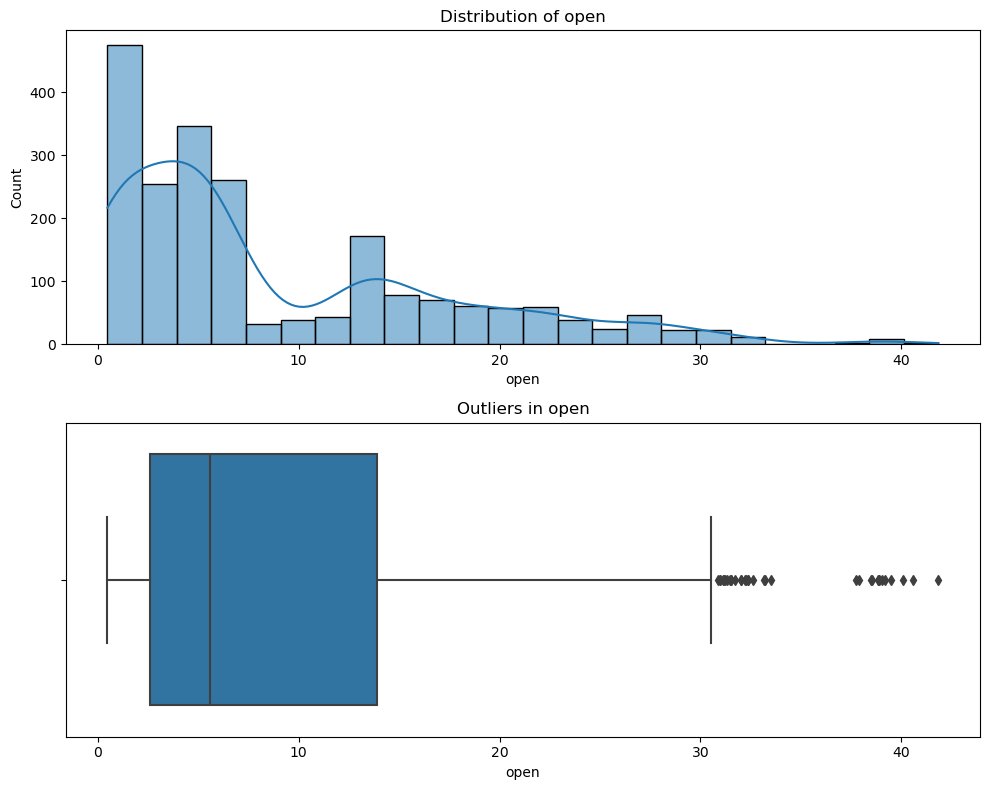

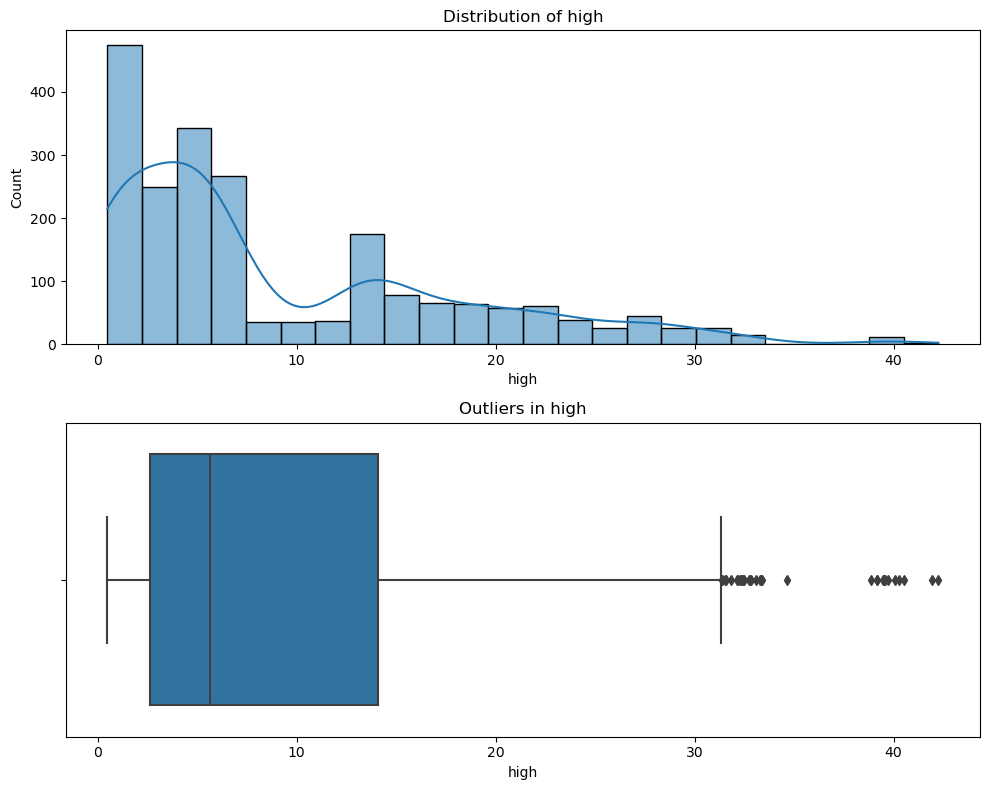

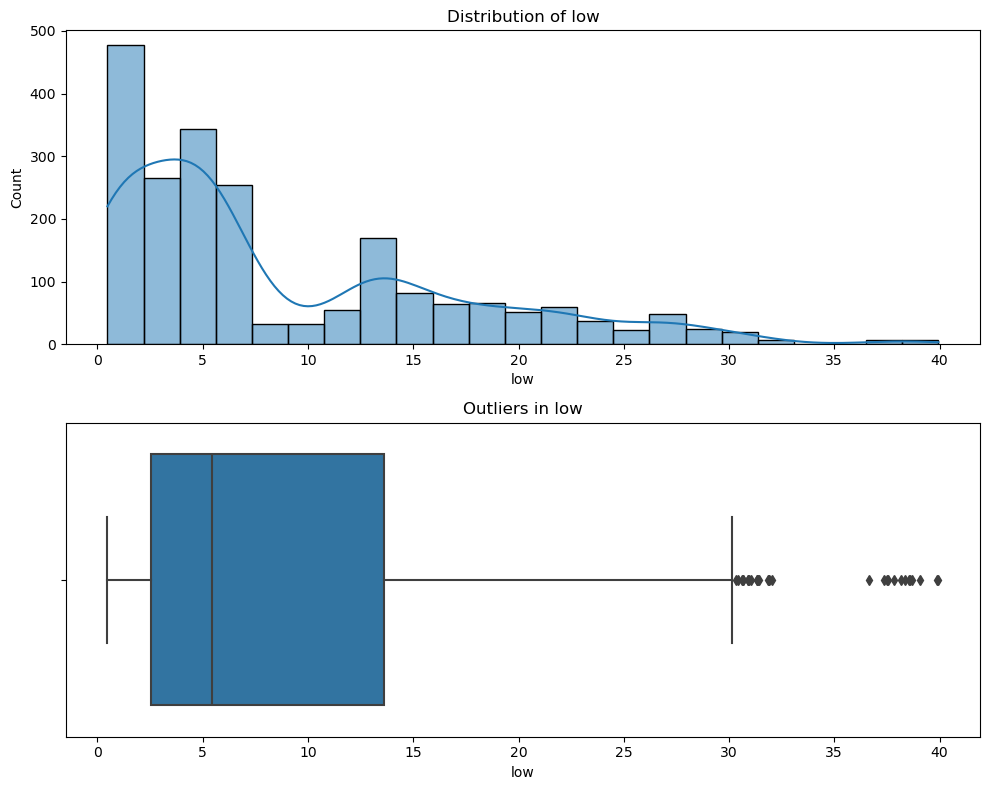

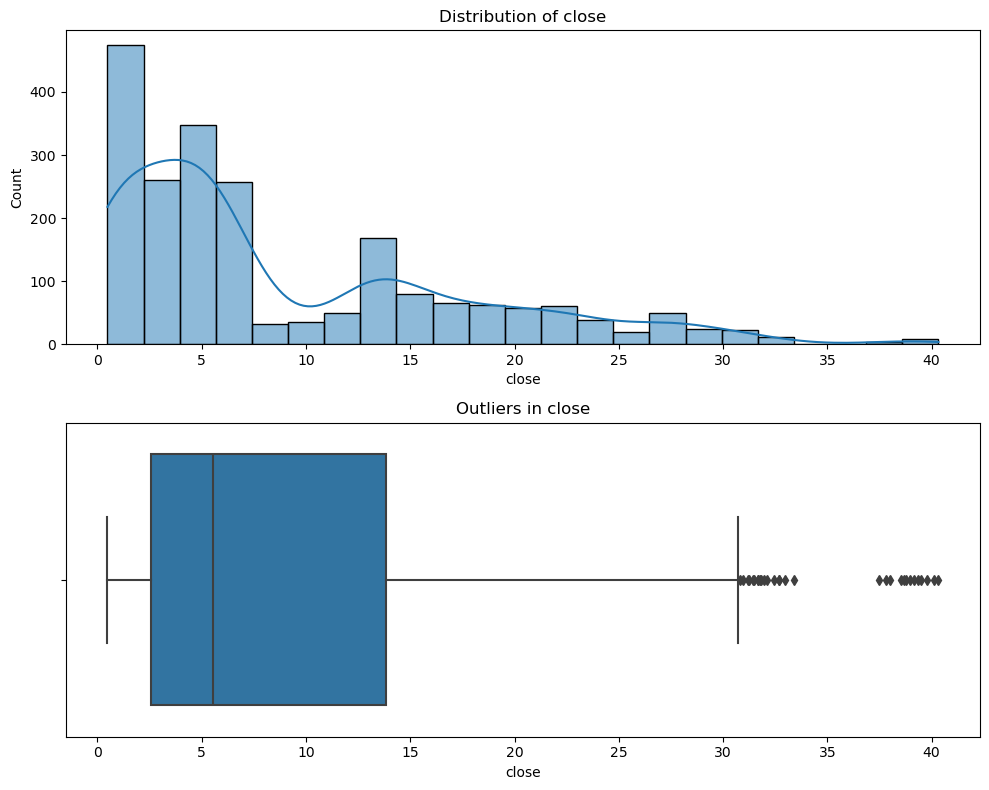

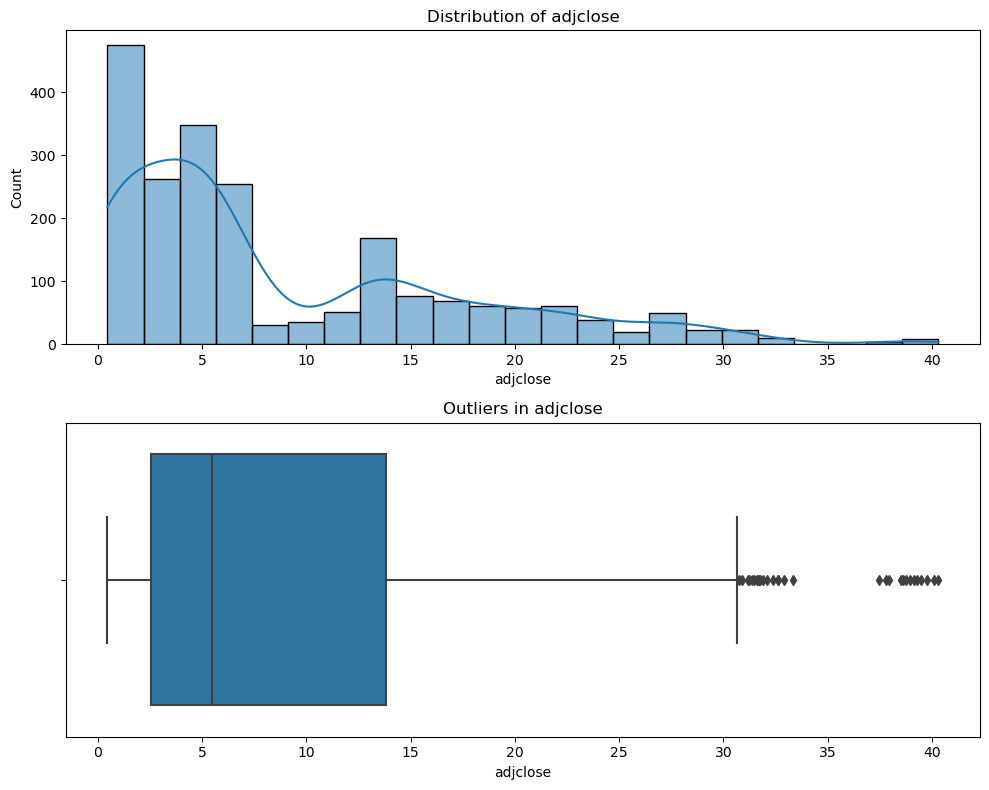

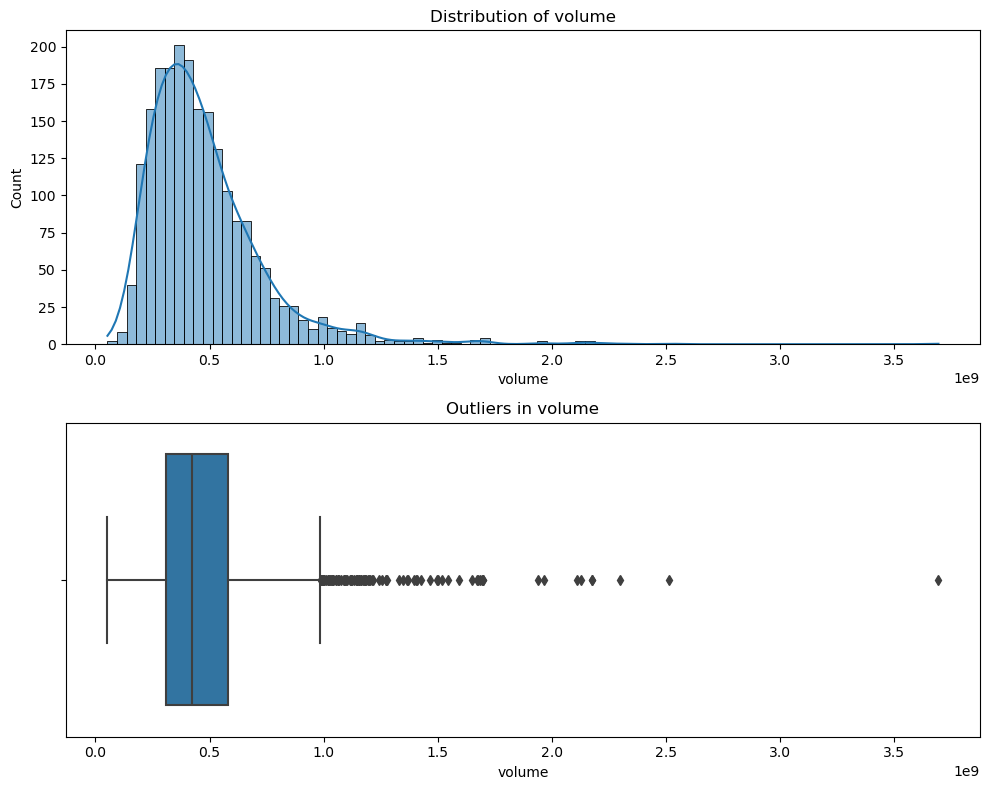

In [61]:
plot_distribution_and_outliers(clean_data_no_outliers, column_names)

In [65]:
def plot_correlation(data, columns):
    """
    This function takes a DataFrame and a list of column names as input.
    It calculates and returns the correlation matrix both as numbers and as a heatmap plot.
    """
    # Select specified columns for correlation
    data_subset = data[columns]
    
    # Calculate correlation matrix
    corr_matrix = data_subset.corr()
    
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix')
    plt.show()
    
    # Return the correlation matrix
    return corr_matrix

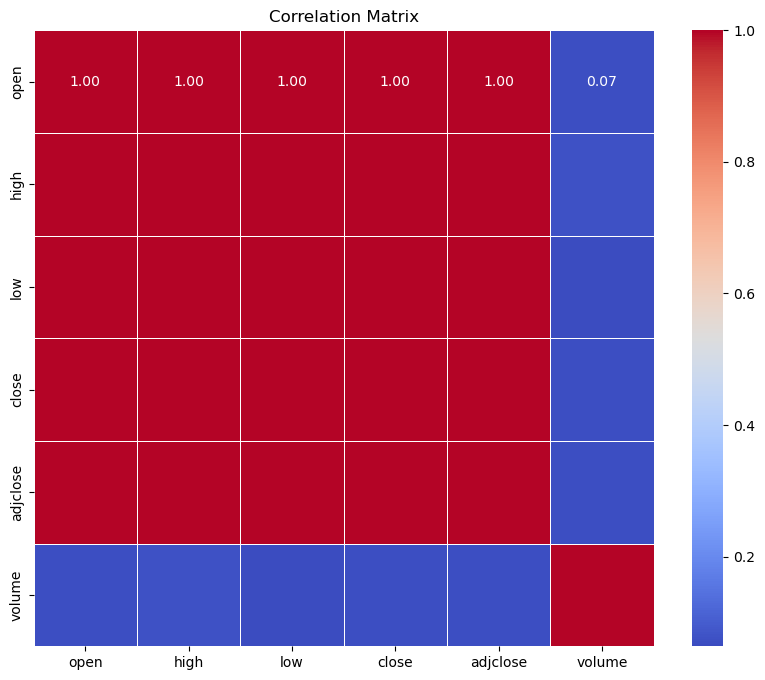

,open,high,low,close,adjclose,volume
open,1.000000,0.999706,0.999654,0.999200,0.999197,0.068857
high,0.999706,1.000000,0.999610,0.999626,0.999626,0.075549
low,0.999654,0.999610,1.000000,0.999649,0.999645,0.063740
close,0.999200,0.999626,0.999649,1.000000,0.999998,0.069997
adjclose,0.999197,0.999626,0.999645,0.999998,1.000000,0.069662
volume,0.068857,0.075549,0.063740,0.069997,0.069662,1.000000


In [66]:
plot_correlation(clean_data_no_outliers, column_names)

In [67]:
feature_columns = ['open', 'high', 'low', 'close', 'volume']
target_column = ['adjclose']

X=clean_data[feature_columns]
y=clean_data[target_column]

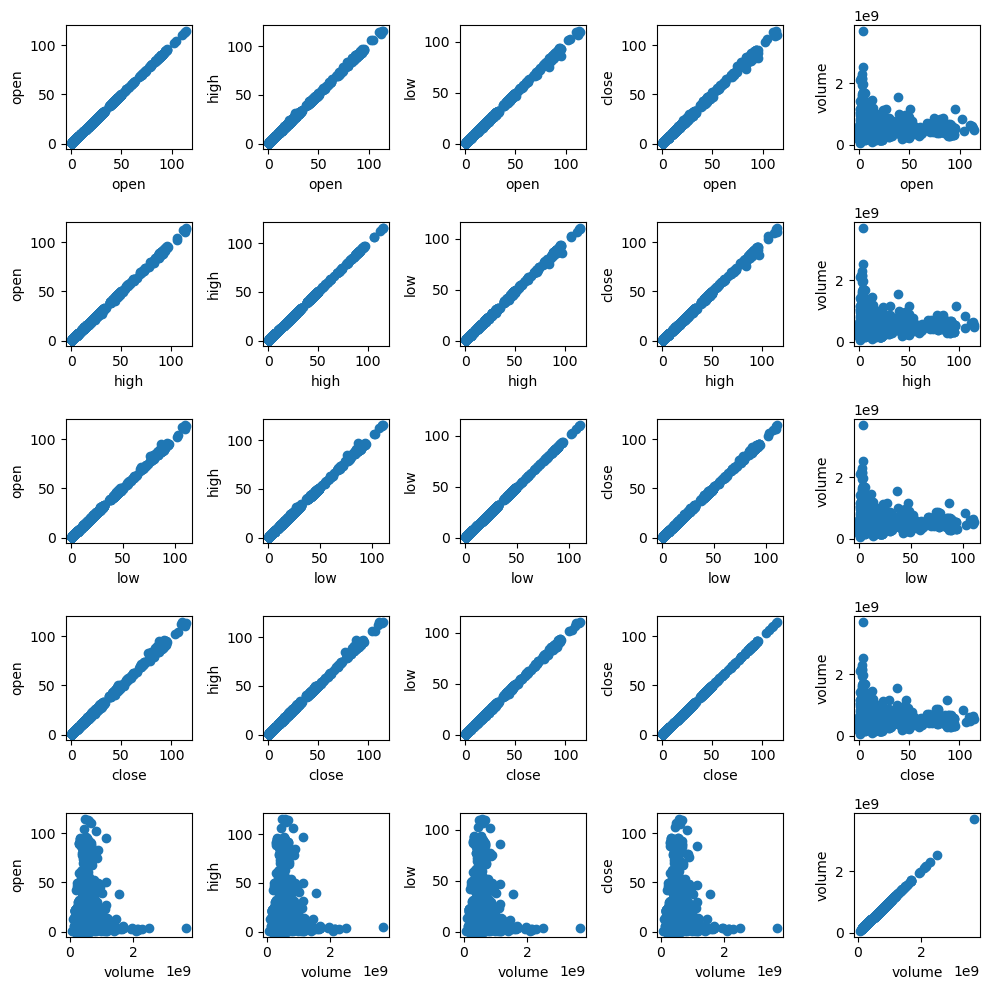

In [68]:
# see relationhip between columns in X. create a loop and plot scatter plot of each column in X within each other
plt.figure(figsize=(10,10))
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        plt.subplot(len(X.columns), len(X.columns), i*len(X.columns)+j+1)
        plt.scatter(X[X.columns[i]], X[X.columns[j]])
        plt.xlabel(X.columns[i])
        plt.ylabel(X.columns[j])
plt.tight_layout()
plt.show()


In [73]:
feature_column=['volume']
target_column=['adjclose']
X=clean_data_no_outliers[feature_column]
y=clean_data_no_outliers[target_column]

In [74]:
#split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
def split_data_fit_model_and_predict_evaluate(X, y, test_size=0.2, random_state=42, model=LinearRegression()):
    """
    Splits the features and target datasets into training and testing sets, fits a specified model,
    and makes predictions on the test set. Evaluates the model's performance.
    
    Parameters:
    - X: Features dataset.
    - y: Target dataset.
    - test_size: Proportion of the dataset to include in the test split (default is 0.2).
    - random_state: Controls the shuffling applied to the data before applying the split (default is 42).
    - model: The machine learning model to be fitted (default is LinearRegression()).
    
    Returns:
    - model: The fitted model.
    - y_pred: Predictions made by the model on the test set.
    - metrics_df: DataFrame containing performance metrics.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Fit the specified model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    std_error = np.sqrt(mse)
    
    # Create a DataFrame to display the metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Mean Squared Error', 'Mean Absolute Error', 'R^2 Score', 'Standard Error'],
        'Value': [mse, mae, r2, std_error]
    })

    return metrics_df

In [76]:
split_data_fit_model_and_predict_evaluate(X, y)

,Metric,Value
0,Mean Squared Error,62.523566
1,Mean Absolute Error,6.773627
2,R^2 Score,-0.001291
3,Standard Error,7.907184
